In [1]:
from __future__ import print_function
import numpy as np
import math
from IPython.display import display
from sympy import *
init_printing()
import matplotlib.pyplot as plt
%matplotlib inline

def display_eq(a,e):
    if isinstance(a, str):
            a = Symbol(a)
    display(Eq(a,e))

## Gaussian Type Orbitals

Gaussian-type orbitals are frequently used for single particle orbitals in QMC.

In [2]:
x,y,z = symbols('x y z')
alpha = Symbol('alpha', positive=True, real=True)
r = Symbol('r',real=True,nonnegative=True)
i,j,k = symbols('i j k',integer=True)
N = Symbol('N')

The form for the primitive orbital is

In [3]:
gto_sym = N * x**i * y**j * z**k * exp(-alpha *r**2)
display(gto_sym)

The normalization ($N$) is given by

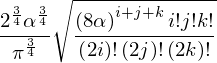

In [4]:
n1 = factorial(i)*factorial(j)*factorial(k)
n2 = factorial(2*i)*factorial(2*j)*factorial(2*k)
norm_sym = (2*alpha/pi)**(3/S(4)) * sqrt((8*alpha)**(i+j+k)*n1/n2)
norm_sym

Sometimes the normalization is written in terms of a double factorial.  The expression can be converted between notations using identities like $\frac{(2i)!}{!i!2^i} = (2i-1)!!$.

For more information, see the [Double Factorial entry at MathWorld](http://mathworld.wolfram.com/DoubleFactorial.html)

QMCPACK splits the normalization between the radial and angular parts.  The normalization can be derived.

### Check normalization

Derive the normalization for the simplest case.

In [5]:
# Derive the normalization for the simplest case (i=j=k=0)
gto000 = gto_sym.subs({N:1,i:0,j:0,k:0})
display_eq('phi_000',gto000)

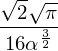

In [6]:
# Integrate the radial part
val_int = integrate(r*r*gto000*gto000, (r,0,oo))
display(val_int)

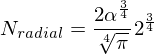

In [7]:
# Normalization for just the radial part
radial_norm = 1/sqrt(val_int)
display_eq('N_radial',radial_norm)

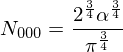

In [8]:
# The full norm includes the factor of 4*pi from the angular integration
full_norm = 1/sqrt(4*pi*val_int)
display_eq('N_000',full_norm)

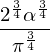

In [9]:
# Compare with the previous expression for N
norm_sym.subs({i:0,j:0,k:0})

### Higher angular momentum
Now check the normalization for higher values of $L=i+j+k$.

In [10]:
# L = i+j+k acts like angular momentum state
L = Symbol('L', integer=True, positive=True)
# Use just powers of x, general enough for now
gtoL00 = gto_sym.subs({N:1,i:L,j:0,k:0})
display_eq('phi_L00',gtoL00)

In [11]:
# Will need some values for the spherical integral
theta = Symbol('theta')
phi = Symbol('phi')
x_in_spherical_coords = r*sin(theta)*cos(phi)
surface_element = r*r*sin(theta)
display_eq('x',x_in_spherical_coords)
surface_element

In [12]:
# substitute x to get the integrand in spherical coordinates
e_sph = gtoL00.subs(Symbol('x'), x_in_spherical_coords)
#display(e_sph)
e_int = e_sph*e_sph*surface_element
e_int

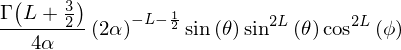

In [13]:
# Perform radial integral
val_L00 = integrate(e_int,(r,0,oo))
val_L00

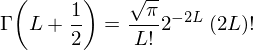

In [14]:
# Replace the Gamma function, from https://en.wikipedia.org/wiki/Gamma_function
gamma_half = 2**(-2*L) *sqrt(pi) * factorial(2*L)/factorial(L)
display_eq(gamma(L+S.Half),gamma_half)

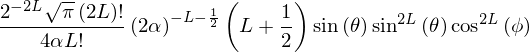

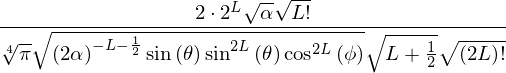

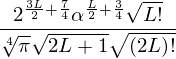

In [15]:
# use gamma(x+1) = x * gamma(x)  and the previous formula
tmp00 = val_L00.subs(gamma(L+3*S.Half), (L+S.Half)*gamma_half)
display(tmp00)
norm_radial_L00 = 1/sqrt(tmp00.rewrite(factorial))
display(norm_radial_L00)

# Remove sin and cos terms
tmp = simplify(norm_radial_L00.subs({sin(theta):1,cos(phi):1}))
tmp

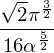

In [16]:
# Integral for general L doesn't seem to work in Sympy, but any particular value of L works
integrate(val_L00.subs(L,1), (theta, 0, pi),(phi,0,2*pi))

### Sum of primitive basis functions

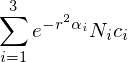

In [17]:
c = IndexedBase('c')
alpha2 = IndexedBase('alpha')
norm2 = IndexedBase('N')
i = Symbol('i',integer=True)
# Fix to size 3, could be general
cg_sym = Sum(norm2[i]*c[i]*gto000.subs(alpha,alpha2[i]),(i,1,3))
cg_sym

In [18]:
# STO-3G for Hydrogen
h_alpha = [3.42525091, 0.62391373, 0.16885540]
h_coeff = [0.15432897, 0.53532814, 0.44463454]
nbasis = len(h_coeff)

cg_unroll = cg_sym.doit()
for idx in range(nbasis):
    cg_unroll = cg_unroll.subs(c[idx+1], h_coeff[idx])
    cg_unroll = cg_unroll.subs(alpha2[idx+1],h_alpha[idx])
    #cg_unroll = cg_unroll.subs(norm2[idx+1],norm_sym.subs({i:0,j:0,k:0,alpha:h_alpha[idx]}))
    print(h_coeff[idx],h_alpha[idx],radial_norm.subs(alpha,h_alpha[idx]).evalf())
    cg_unroll = cg_unroll.subs(norm2[idx+1],radial_norm.subs({alpha:h_alpha[idx]}))

cg_unroll.evalf()

0.15432897 3.42525091 6.36113067148303
0.53532814 0.62391373 1.77361123608569
0.44463454 0.1688554 0.665504872778405


In [19]:
# Evaluate at a concrete value for r
cg_unroll.subs(r,1.3).evalf()

In [20]:
# Can check derivatives as well
d_cg = diff(cg_unroll, r)
d_cg.subs(r, 1.3).evalf()

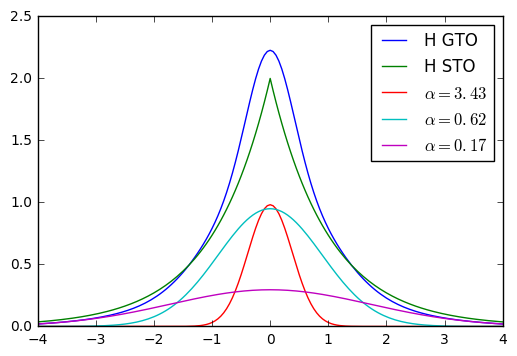

In [23]:
# Plot the primitive gaussians, the overall GTO, and the STO it mimics

nplot = 161
delta_plot = .05
rvals = np.zeros(nplot)
yvals = np.zeros(nplot)
indvals = np.zeros((3,nplot))
stovals = np.zeros(nplot)
for i in range(nplot):
    rval = i*delta_plot - 4.0
    y = cg_unroll.subs(r,rval).evalf()
    rvals[i] = rval
    yvals[i] = y
    stovals[i] = 2.0*math.exp(-abs(rval))
    for j in range(3):
        val = h_coeff[j]*gto000.subs({alpha:h_alpha[j], r:rval})*radial_norm.subs({alpha:h_alpha[j]}).evalf()
        #print(val)
        indvals[j,i] = val
    
plt.plot(rvals, yvals, label='H GTO')
plt.plot(rvals, stovals, label='H STO')
plt.plot(rvals, indvals[0,:], label= r'$\alpha=%.2f$'%h_alpha[0])
plt.plot(rvals, indvals[1,:], label= r'$\alpha=%.2f$'%h_alpha[1])
plt.plot(rvals, indvals[2,:], label= r'$\alpha=%.2f$'%h_alpha[2])
plt.legend()

In [22]:
# Compute normalization for STO for previous plot
sto00 = exp(-r)
val = integrate(sto00*sto00*r*r,(r,0,oo))
1/math.sqrt(val)